## Retomando: predecir progresión de cancer de mama

Vamos a usar un dataset compilado y donado por el Dr. William Wolberg de la Universidad de California at Irvine. Es de 1992 y ya hay mucho trabajo sobre uso de este dataset para desarrollar y evaluar algoritmos de predicción (ver referencias).

El dataset tiene:
Number of Samples: 569
Number of Features: 30 numeric, predictive attributes
Number of Classes: 2

Referencias:

 - Wolberg, William. (1992). Breast Cancer Wisconsin (Original). UCI Machine Learning Repository. [Original Wisconsin Breast Cancer Database](https://doi.org/10.24432/C5HP4Z).
 - O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.
 - William H. Wolberg and O.L. Mangasarian: "Multisurface method of pattern separation for medical diagnosis applied to breast cytology", Proceedings of the National Academy of Sciences, U.S.A., Volume 87, December 1990, pp 9193-9196.
 - O. L. Mangasarian, R. Setiono, and W.H. Wolberg: "Pattern recognition via linear programming: Theory and application to medical diagnosis", in: "Large-scale numerical optimization", Thomas F. Coleman and Yuying Li, editors, SIAM Publications, Philadelphia 1990, pp 22-30.
 - K. P. Bennett & O. L. Mangasarian: "Robust linear programming discrimination of two linearly inseparable sets", Optimization Methods and Software 1, 1992, 23-34 (Gordon & Breach Science Publishers).

In [179]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt

In [180]:
# el dataset Wisconsin Breast Cancer (UCI) de Wolberg está en sklearn!
from sklearn import datasets

# sklearn.datasets nos trae los datos con una estructura particular
# sklearn los llama "bunchs"
# as_frame = True nos devuelve un dataframe pandas embebido en el bunch
wbc = datasets.load_breast_cancer(as_frame=True)

# y guardamos el dataframe
df = wbc.frame

In [ ]:
# generamos nuestros vectores x (datos) -- copiamos el dataframe entero y le borramos la columna 'target' con las etiquetas
x = df.drop(['target'], axis=1)

# y nuestro vector y (etiquetas)
y = df['target']
x.head()

In [182]:
# normalizar / estandarizar / re-escalar datos
import numpy as np

from sklearn.preprocessing import MinMaxScaler
#n = (x - np.min(x, axis=0)) / ((np.max(x, axis=0)) - np.min(x, axis=0)).values
scaler = MinMaxScaler().fit(x)

# n son nuestros datos normalizados!
n = scaler.transform(x)


In [183]:
from sklearn.model_selection import train_test_split

# notar que usamos n en lugar de x (datos normalizados!)
x_train, x_test, y_train, y_test = train_test_split(n, y, test_size=0.15, random_state=666)

In [187]:
from sklearn.linear_model import LogisticRegression

# y con esto vamos a entrenar
lr = LogisticRegression(penalty="l2")
lr.fit(x_train,y_train)
y_scores = lr.predict_proba(x_test)[:, 1]

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)

In [234]:
#@title Plotear Curvas ROC + Precision-Recall

def ajustar_clases(y_scores, t):
    """
    La funcion ajusta las predicciones de clases / etiquetas
    de acuerdo a un umbral (threshold (t)).
    Solo funciona para problemas de clasificacion binaria!
    """
    return [1 if y >= t else 0 for y in y_scores]


def precision_recall_threshold(precision, recall, thresholds, t=0.5, label=None):
    """
    plotea la curva precision-recall y muestra el punto
    donde está el umbral del clasificador.
    """

    # acá generamos nuevas etiquetas / clases (o sea nuestras prediccines)
    # en base a un nuevo umbral - el umbral es que que vuelve a redefinir
    # TP, TN, FP, FN -- y por lo tanto la nueva matriz de confusion
    y_pred_adj = ajustar_clases(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                         columns=['pred_neg', 'pred_pos'],
                         index=['neg', 'pos']))


    # plot the curve
    plt.figure(figsize=(8, 3))
    lw = 2
    plt.subplot(1,1,1)
    plt.step(recall, precision, color='orange', where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Curva Precision-Recall con Umbral')
    plt.grid(True)
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(recall[close_default_clf], precision[close_default_clf], 'o', c='red', markersize=8)


def plot_roc_curve(fpr, tpr, roc_auc):
    """
    The ROC curve, modified from
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8, 3))
    lw = 2
    plt.subplot(1,1,1)
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.fill_between(fpr,tpr, step='post', alpha=0.5, color='orange')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)



In [155]:
#@title Función para plotear matrices de confusión
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cf, generica=False):
  # cf is the confusion matrix
  #
  # Plot the confusion matrix using Matplotlib
  #
  # define fontsize here
  fs = 12
  #
  if (generica):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(cf, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cf.shape[0]):
      for j in range(cf.shape[1]):
          if (i == j):
            texto = "Clase " + str(i)
            ax.text(x=j, y=i,s=texto, va='center', ha='center', size='x-large')
          else:
            texto = "No-" + str(i)
            ax.text(x=j, y=i,s=texto, va='center', ha='center', size='x-large')
  else:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(cf, cmap=plt.cm.Greens, alpha=0.3)
    for i in range(cf.shape[0]):
      for j in range(cf.shape[1]):
          ax.text(x=j, y=i,s=cf[i, j], va='center', ha='center', size='x-large')

  plt.xlabel('Predicciones', fontsize=fs)
  plt.ylabel('Clases Reales', fontsize=fs)
  plt.title('Matriz de Aciertos y Confusiones', fontsize=fs)
  plt.show()

     pred_neg  pred_pos
neg        32         3
pos         1        50


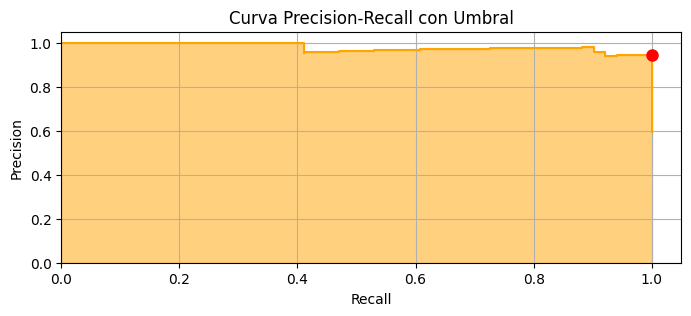

In [212]:
precision_recall_threshold(precision, recall, thresholds, 0.56)

In [200]:
#@title Funcion para plotear Precision vs Recall vs Umbral
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 5))
    plt.title("Precision vs Recall en funcion del Umbral")
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision")
    plt.plot(thresholds, recalls[:-1], "m-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Threshold / Umbral")
    plt.legend(loc='best')

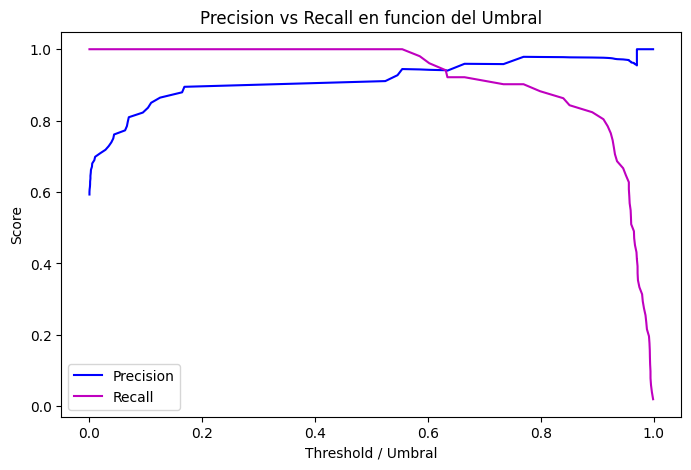

In [191]:
# usamos los mismos valores (precision, recall, thresholds) que obtuvimos antes
plot_precision_recall_vs_threshold(precision, recall, thresholds)

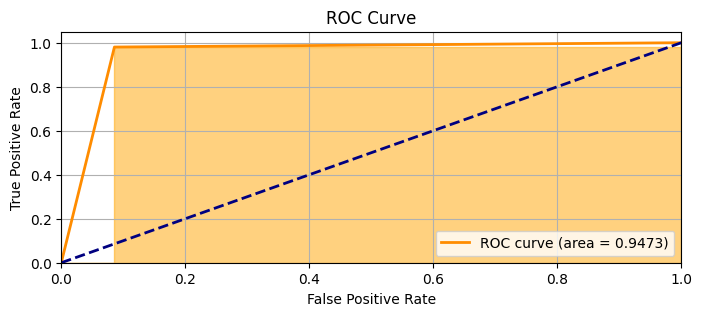

In [240]:
umbral = 0.58
y_scores_ajustados = pd.Series(ajustar_clases(y_scores, umbral))
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores_ajustados)
# Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
roc_auc = roc_auc_score(y_test, y_scores_ajustados)
plot_roc_curve(fpr, tpr, roc_auc)

## Aumentando la confusión

Cuando tenemos un problema de clasificación binario, nuestro predictor etiqueta a los datos en dos clases (1, 0); (positivo, negativo); (sano, enfermo).

Qué pasa cuando tenemos más clases?

Cómo son nuestras matrices de confusión en este caso? ### Tablas de Aciertos y Desaciertos Matrices 3D de

The data is the results of a chemical analysis of wines grown in the same
region in Italy by three different cultivators. There are thirteen different
measurements taken for different constituents found in the three types of
wine.

In [ ]:
# el dataset Wisconsin Breast Cancer (UCI) de Wolberg está en sklearn!
from sklearn import datasets

# sklearn.datasets nos trae los datos con una estructura particular
# sklearn los llama "bunchs"
# as_frame = True nos devuelve un dataframe pandas embebido en el bunch
wwine = datasets.load_wine(as_frame=True)

# y guardamos el dataframe
df = wwine.frame
df.head()

In [ ]:
print(wwine.DESCR)

In [ ]:
# veamos las etiquetas de las clases (targets), los 3 cultivares
print(wwine.target_names)

In [2]:
# generamos nuestros vectores x (datos) -- copiamos el dataframe entero y le borramos la columna 'target' con las etiquetas
x = df.drop(['target'], axis=1)

# y nuestro vector y (etiquetas)
y = df['target']

In [33]:
# entrenar el modelo
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

# con pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# split entre train / test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state=21)

pipe = Pipeline([
        ('scale', MinMaxScaler()),
        ('logistic_regression', LogisticRegression()),
        ])

pipe.fit(x_train, y_train)
clasificacion = pipe.predict(x_test)
probabilidades = pipe.predict_proba(x_test)

In [ ]:
lr = pipe.named_steps['logistic_regression']
coeficientes = lr.coef_[0]

import pandas as pd
import numpy as np

feature_importance = pd.DataFrame({'Feature': x.columns, 'Importance': np.abs(coeficientes)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

accuracy = round(accuracy_score(y_test, clasificacion), 3)
precision = round(precision_score(y_test, clasificacion, average='micro'), 3)
recall = round(recall_score(y_test, clasificacion, average='micro'), 3)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Exactitud (Accuracy): {accuracy}")
print(f"Precisión: {precision}")
print(f"Exhaustividad (Recall): {recall}")
print(f"F1-Score: {f1_score}")


In [8]:
#@title Función para plotear matrices de confusión
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cf, generica=False):
  # cf is the confusion matrix
  #
  # Plot the confusion matrix using Matplotlib
  #
  # define fontsize here
  fs = 12
  #
  if (generica):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(cf, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cf.shape[0]):
      for j in range(cf.shape[1]):
          if (i == j):
            texto = "Clase " + str(i)
            ax.text(x=j, y=i,s=texto, va='center', ha='center', size='x-large')
          else:
            texto = "No-" + str(i)
            ax.text(x=j, y=i,s=texto, va='center', ha='center', size='x-large')
  else:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(cf, cmap=plt.cm.Greens, alpha=0.3)
    for i in range(cf.shape[0]):
      for j in range(cf.shape[1]):
          ax.text(x=j, y=i,s=cf[i, j], va='center', ha='center', size='x-large')

  plt.xlabel('Predicciones', fontsize=fs)
  plt.ylabel('Clases Reales', fontsize=fs)
  plt.title('Matriz de Aciertos y Confusiones', fontsize=fs)
  plt.show()

In [ ]:
# Matriz de confusion
matriz_de_confusion = metrics.confusion_matrix(y_test, clasificacion)
plot_confusion_matrix(matriz_de_confusion, generica=False)

# Ejercicio: otro caso multilabel

En este caso vamos a ver las curvas ROC con un dataset un poco mas dificil (para que las curvas ROC no sean tan perfectas!)

In [251]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
target_names = iris.target_names
x, y = iris.data, iris.target
y = iris.target_names[y]

# agregamos un poco de ruido a los datos para hacer el problema mas dificil
random_state = np.random.RandomState(0)
n_samples, n_features = x.shape
n_classes = len(np.unique(y))
x = np.concatenate([x, random_state.randn(n_samples, 200 * n_features)], axis=1)
(
    x_train,
    x_test,
    y_train,
    y_test,
) = train_test_split(x, y, test_size=0.5, stratify=y, random_state=0)



In [252]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
y_score = classifier.fit(x_train, y_train).predict_proba(x_test)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

In [ ]:
label_binarizer.transform(["virginica"])

In [52]:
lr = LogisticRegression()
probabilidades = lr.fit(x_train, y_train).predict_proba(x_test)

In [ ]:
class_of_interest = "virginica"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    #plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

### Jugando con datos sintéticos

## Generamos nuestros datos

Vamos a generar dos clases con distribución normal (simétrica, gausiana). En ambos casos las clases muestran distribuciones _balanceadas_.

Para imaginar situaciones reales, piensen en que las dos clases pueden ser dos grupos de pacientes (enfermos, sanos). O dos grupos de estudiantes (universitarios _vs_ colegio secundario). O dos grupos de atletas entrenados para correr 100 metros (jamaiquinos _vs_ argentinos).

En cualquiera de estos ejemplos, contamos con el resultado numérico de algún un test nos va a permitir (con suerte) separar a estas dos clases. Por ejemplo: velocidad en que corren los 100metros (corredores), resultado de medir algun parámetro en sangre en un análisis bioquímico de laboratorio (pacientes), o resultado de la nota en un examen escrito o multiple choice (alumnos).

El test nos da un puntaje numérico con valores entre 0 y 10. En el caso de un examen escrito para estudiantes, no nos cuesta mucho imaginarlo. En el caso de tiempo en correr 100m (atletas) o en el caso de algun análisis diagnóstico de laboratorio, imaginemos que los puntajes fueron _normalizados_ o _re-escalados_ para que entren en este rango.

In [241]:
# vmos a generar datos balanceados (10000 por lado)
N1 = 10000
media1 = 4
sigma1 = 1

N2 = 10000
media2 = 7
sigma2 = 1

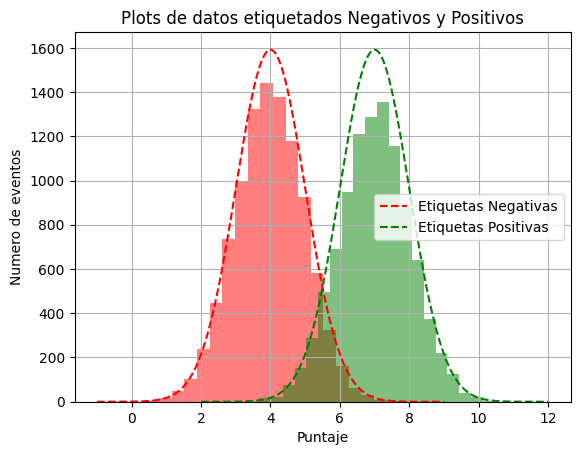

In [243]:
#@title Generar Datos y Plotear Dataset
#
from scipy.stats import norm
def distribucion_normal(media, sigma, N, bins, label, plt_color, is_plot=True):
  # simulamos puntajes con una distribucion a partir de la media, desvio y nro de datos (N)
  puntajes = np.sort(norm.rvs(loc=media, scale=sigma, size=N))

  # Curva Bell de Referencia
  x = np.linspace(-5, 5, N)
  # por defecto centrada en 0 y con desvio 1
  bell = norm.pdf(x) * N * max(norm.pdf(x))

  if is_plot:
    plt.hist(puntajes, density=False, color=plt_color, alpha=.5, bins=bins)
    plt.plot(x+media, bell, '--', label=label, color=plt_color)

  return puntajes, x, bell

BINS = 20

plt.figure()

# Distribucion de datos etiquetados como Negativos
label1 = 'Etiquetas Negativas'
puntajes1, x1, bell1 = distribucion_normal(media1, sigma1, N1, BINS, label1, plt_color='red')

label2 = 'Etiquetas Positivas'
puntajes2, x2, bell2 = distribucion_normal(media2, sigma2, N2, BINS, label2, plt_color='green')

# Finalmente generamos nuestros vectores x (datos) + y (etiquetas)
y = N1*[0] + N2*[1]

x = np.concatenate((puntajes1, puntajes2), axis=None).reshape(-1,1)

# Plot
plt.title("Plots de datos etiquetados Negativos y Positivos")
plt.xlabel('Puntaje')
plt.ylabel('Numero de eventos')
plt.grid(True)
plt.legend()
plt.show()

El código oculto nos genera datos en nuestros vectores `x`(datos, valores) e `y` (clases, etiquetas). Las etiquetas son: POSITIVO (`1`) o NEGATIVO (`0`). Y los puntajes son los valores numéricos que surjen de algún test. Con esta informacion entrenamos un modelo Logistico:

In [245]:
# entrenar el modelo
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# con pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# split entre train / test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state=21)

pipe = Pipeline([
        ('scale', MinMaxScaler()),
        ('logistic_regression', LogisticRegression()),
        ])

pipe.fit(x_train, y_train)
clasificacion = pipe.predict(x_test)
y_scores = pipe.predict_proba(x_test)


In [246]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

print(f"Exactitud: {round(accuracy_score(y_test, clasificacion), 3)}      (TP + TN / P + N)")
print(f"Precisión: {round(precision_score(y_test, clasificacion), 3)}      (TP / TP + FP)")
print(f"Exhaustividad: {round(recall_score(y_test, clasificacion), 3)}  (TP / TP + FN)")
print("\nMatriz de confusión:")
print(metrics.confusion_matrix(y_test, clasificacion))

Exactitud: 0.933      (TP + TN / P + N)
Precisión: 0.937      (TP / TP + FP)
Exhaustividad: 0.931  (TP / TP + FN)

Matriz de confusión:
[[1392   95]
 [ 105 1408]]


# Apendice

## Ejercicios Extra con Cross Validation + Optimizacion de Hiperparámetros

A continuación algunos ejercicios más para que prueben Cross Validation y un GridSearch buscando los mejores hiperparámetros

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt

In [ ]:
# el dataset Wisconsin Breast Cancer (UCI) de Wolberg está en sklearn!
from sklearn import datasets

# sklearn.datasets nos trae los datos con una estructura particular
# sklearn los llama "bunchs"
# as_frame = True nos devuelve un dataframe pandas embebido en el bunch
wbc = datasets.load_breast_cancer(as_frame=True)

# y guardamos el dataframe
df = wbc.frame

In [ ]:
# generamos nuestros vectores x (datos) -- copiamos el dataframe entero y le borramos la columna 'target' con las etiquetas
x = df.drop(['target'], axis=1)

# y nuestro vector y (etiquetas)
y = df['target']
x.head()

Un clasificador que todavía no vimos (RandomForest). Usenlo a ciegas por ahora, comparen resultados con LogisticRegression.

In [ ]:
# optimizar
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10],
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

Y acá, escrito en forma de función de python, algo de código que envuelve (wraps) la ejecución de nuestro GridSearch para búsqueda de hiperparametros + parametros. Fijense que está todo acá CrossValidation (`cv=`), Hiperparametros (`param_grid`), y el score que vamos a querer optimizar (`refit=`).

La función necesita nuestro clasificador (`clf`), y qué cosa `priorizar` (ver `scorers` arriba). Se usa así:
```
grid_search_wrapper(clf, priorizar="accuracy_score")
```

In [ ]:
#@title Wrapper para optimizar parametros para un score particular
def grid_search_wrapper(clf, priorizar='precision_score'):
    """
    fitea un clasificador GridSearchCV priorizando un score
    en particular (priorizar) para optimizar
    devuelve metricas de performance del clasificador
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=priorizar,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(x_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(x_test.values)

    print('Mejores parametros para {}'.format(priorizar))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nMatriz de Confusion optimizada para {} sobre los datos de validación:'.format(priorizar))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [ ]:
grid_search_clf = grid_search_wrapper(clf, priorizar='precision_score')


In [ ]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results


In [ ]:
y_scores = grid_search_clf.predict_proba(x_test)[:, 1]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
